In [1]:
import numpy as np
import pandas as pd
import datatable as dt
import os , sys
from pyunpack.cli import Archive
import matplotlib.pyplot as plt
import seaborn as sns

Распаковываем изначальный архив

In [4]:
import zipfile_deflate64 as zipfile
with zipfile.ZipFile('kkbox-music-recommendation-challenge.zip', 'r', allowZip64=True) as zip_ref:
    # print(zip_ref.infolist())
    zip_ref.extractall()

Распаковываем каждый из файлов

In [60]:
import py7zr

with py7zr.SevenZipFile('members.csv.7z', mode='r') as z:
    z.extractall()

with py7zr.SevenZipFile('sample_submission.csv.7z', mode='r') as z:
    z.extractall()

with py7zr.SevenZipFile('song_extra_info.csv.7z', mode='r') as z:
    z.extractall()

with py7zr.SevenZipFile('songs.csv.7z', mode='r') as z:
    z.extractall()

with py7zr.SevenZipFile('train.csv.7z', mode='r') as z:
    z.extractall()

with py7zr.SevenZipFile('test.csv.7z', mode='r') as z:
    z.extractall()

Загружаем данные в переменные изпользуя библиотеку datatable из-за большей скорости считывания

In [2]:
train_df = dt.fread('train.csv').to_pandas()
songs_df = dt.fread('songs.csv').to_pandas()
members_df = dt.fread('members.csv').to_pandas()

Проверяем пропуски и типы данных

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   msno                object
 1   song_id             object
 2   source_system_tab   object
 3   source_screen_name  object
 4   source_type         object
 5   target              bool  
dtypes: bool(1), object(5)
memory usage: 288.5+ MB


Пропуски не показаны, значит проверяем отдельно

In [4]:
train_df.isnull().sum()

msno                  0
song_id               0
source_system_tab     0
source_screen_name    0
source_type           0
target                0
dtype: int64

Пропусков нет, просматриваем несколько строчек данных

In [5]:
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,True
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,True
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,True
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,True
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,True


Строим гистограммы распределения данных по каждому категориальному признаку

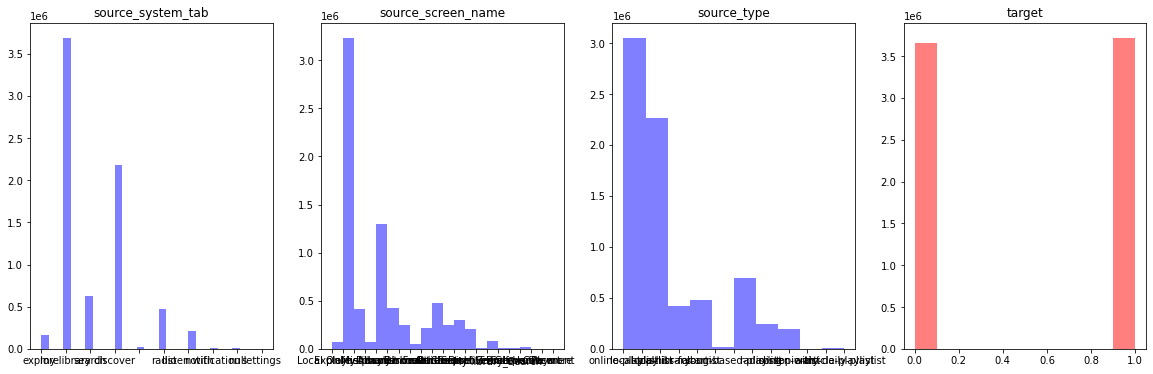

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

axs[0].hist(train_df['source_system_tab'], bins=30, color='blue', alpha=0.5)
axs[0].set_title('source_system_tab')
axs[1].hist(train_df['source_screen_name'], bins=20, color='blue', alpha=0.5)
axs[1].set_title('source_screen_name')
axs[2].hist(train_df['source_type'], bins=10, color='blue', alpha=0.5)
axs[2].set_title('source_type')
axs[3].hist(train_df['target'].astype(int), color='red', alpha=0.5)
axs[3].set_title('target')

plt.show()

Можно увидеть что дизбаланса классов таргета нет

Теперь смотрим наличие пропусков для songs_df

In [14]:
songs_df.isnull().sum()

song_id        0
song_length    0
genre_ids      0
artist_name    0
composer       0
lyricist       0
language       1
dtype: int64

есть один пропуск в признаке язык

смотрим распределение по genre_ids

In [16]:
songs_df.genre_ids.value_counts()

genre_ids
465              567911
958              176349
2022             168870
1609             166457
2122             139938
                  ...  
465|139|388           1
409|1609              1
139|94|2022           1
352|1944|1995         1
1138|2022             1
Name: count, Length: 1046, dtype: int64

Добавляем столбцы для кажого типа с помощью разбиения по |

In [17]:
df_idx = songs_df["genre_ids"].str.split('|')
df_idx.head()

0    [465]
1    [444]
2    [465]
3    [465]
4    [726]
Name: genre_ids, dtype: object

In [18]:
songs_df = pd.concat([songs_df.drop('genre_ids', axis = 1 ), df_idx.apply(pd.Series)], axis=1)
songs_df.head()

,song_id,song_length,artist_name,composer,lyricist,language,0,1,2,3,4,5,6,7
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,張信哲 (Jeff Chang),董貞,何啟弘,3.0,465,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0,444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,SUPER JUNIOR,,,31.0,465,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,S.H.E,湯小康,徐世珍,3.0,465,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,貴族精選,Traditional,Traditional,52.0,726,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
songs_df[songs_df['composer'].str[:6] == 'Korean'].language.value_counts()

language
31.0    125
3.0      27
52.0      2
Name: count, dtype: int64

Заполняем пропущенное значение на основе самых распространённых среди корейских исполнителей

In [20]:
songs_df.loc[songs_df['language'].isnull(), 'language'] = 31.0

In [27]:
songs_df['song_length'].astype(int)

0          247640
1          197328
2          231781
3          273554
4          140329
            ...  
2296315     20192
2296316    273391
2296317    445172
2296318    172669
2296319    270466
Name: song_length, Length: 2296320, dtype: int32

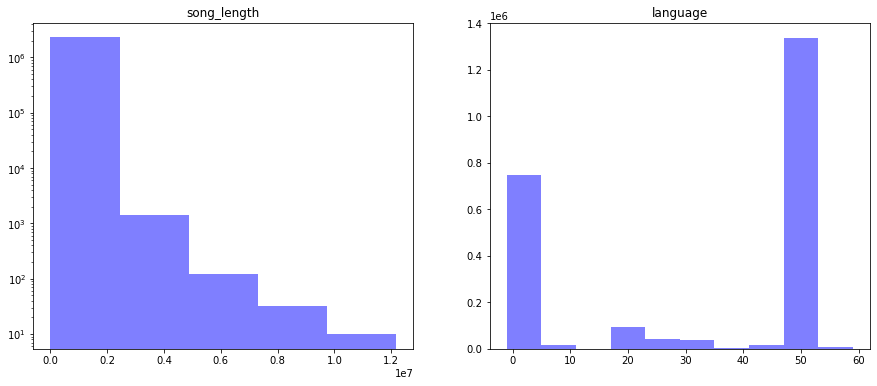

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].hist(songs_df['song_length'].astype(int), bins=5, color='blue', alpha=0.5)
axs[0].set_title('song_length')
axs[0].set_yscale('log')
axs[1].hist(songs_df['language'], bins=10, color='blue', alpha=0.5)
axs[1].set_title('language')

plt.show()

In [38]:
members_df.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,,4,20170126,20170613


Заменяем дату на конкретные значения дня месяца и года

In [39]:
members_df['registration_init_time'] = pd.to_datetime(members_df['registration_init_time'], format='%Y%m%d')

members_df['reg_year'] = members_df['registration_init_time'].dt.year
members_df['reg_month'] = members_df['registration_init_time'].dt.month
members_df['reg_day'] = members_df['registration_init_time'].dt.day


In [40]:
members_df['expiration_date'] = pd.to_datetime(members_df['expiration_date'],  format='%Y%m%d')
members_df['exp_year'] = members_df['expiration_date'].dt.year
members_df['exp_month'] = members_df['expiration_date'].dt.month
members_df['exp_day'] = members_df['expiration_date'].dt.day

In [41]:
members_df.drop(['registration_init_time','expiration_date'], axis = 1, inplace=True)

In [42]:
members_df.head()

,msno,city,bd,gender,registered_via,reg_year,reg_month,reg_day,exp_year,exp_month,exp_day
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,,7,2011,8,20,2017,9,20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,,7,2015,6,28,2017,6,22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,,4,2016,4,11,2017,7,12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,,9,2015,9,6,2015,9,7
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,,4,2017,1,26,2017,6,13


аномальное каличество 0

In [45]:
members_df['bd'].value_counts()

bd
0      19932
22       751
27       750
24       740
26       719
       ...  
97         1
76         1
103        1
101        1
10         1
Name: count, Length: 95, dtype: int64

In [46]:
members_df['bd'] = members_df['bd'].apply(lambda x : 0 if x > 100 else abs(x))

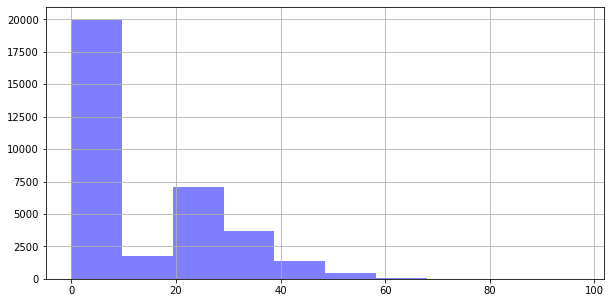

In [48]:
plt.figure(figsize=(10, 5))
members_df['bd'].hist(bins=10, color='blue', alpha=0.5)
plt.show()

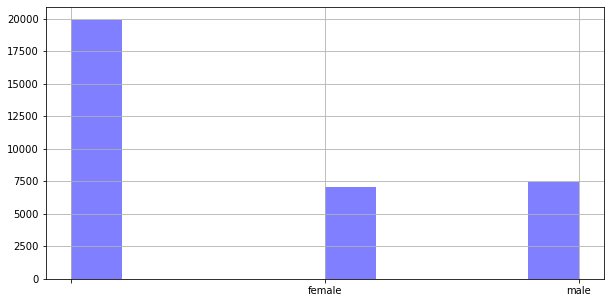

In [49]:
plt.figure(figsize=(10, 5))
members_df['gender'].hist(bins=10, color='blue', alpha=0.5)
plt.show()

In [50]:
members_df['gender'] = members_df['gender'].astype("category").cat.codes

построим модель catboost для нивелирования этих ошибок

In [51]:
train_age = members_df[members_df['bd'] != 0].copy() 
y_train_age  = train_age['bd']
train_age.drop(['msno' ,'bd','gender'],axis = 1 , inplace = True)

test_age =  members_df[members_df['bd'] == 0].copy() 
y_test_age  = test_age['bd']
test_age.drop(['msno' ,'bd','gender'],axis = 1 , inplace = True)

In [52]:
train_age.head()

,city,registered_via,reg_year,reg_month,reg_day,exp_year,exp_month,exp_day
5,13,9,2012,7,3,2017,10,6
10,12,9,2006,5,31,2017,8,16
13,15,3,2015,9,15,2017,10,19
15,13,3,2014,4,10,2017,4,27
16,13,9,2007,3,30,2017,6,12


In [53]:
from lightgbm import LGBMClassifier , LGBMRegressor
from catboost import CatBoostClassifier ,CatBoostRegressor

from sklearn.model_selection import GridSearchCV , cross_val_score
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

In [54]:
model = CatBoostRegressor(task_type='GPU', verbose=0)
model.fit(train_age.values, y_train_age.values)
cv_score = np.sqrt(-cross_val_score(model, train_age.values,y_train_age.values.ravel(), cv=3 ,scoring='neg_mean_squared_error').mean())
cv_score

8.716434542546017

In [55]:
pred_age = model.predict(test_age.values)
pred_age = pred_age.round()
pred_age

array([35., 26., 25., ..., 29., 28., 27.])

In [27]:
members_df['bd'].value_counts()

bd
0     19954
22      751
27      750
24      740
26      719
      ...  
90        1
2         1
70        1
3         1
10        1
Name: count, Length: 80, dtype: int64

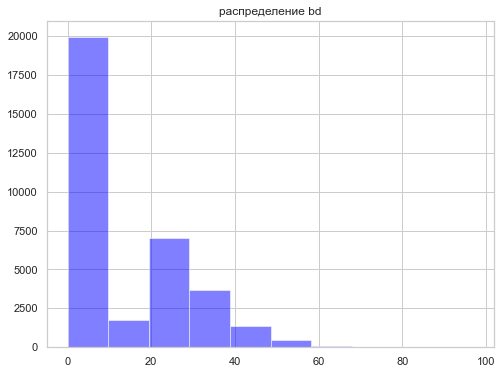

In [57]:
plt.figure(figsize=(8, 6))

members_df['bd'].hist(bins=10, color='blue', alpha=0.5)

plt.title('распределение bd')

plt.show()

In [58]:
age_nulls_indexes = members_df[members_df['bd'] == 0].index
j = 0
for i in age_nulls_indexes : 
    members_df.loc[i , 'bd'] = pred_age[j]
    j += 1

In [59]:
members_df['bd'].value_counts()

bd
28    5589
27    4261
26    3932
25    3227
29    2290
      ... 
90       1
76       1
2        1
97       1
10       1
Name: count, Length: 79, dtype: int64

Аномальные значения ушли, но добавилось сильное превосхождение определённого значения

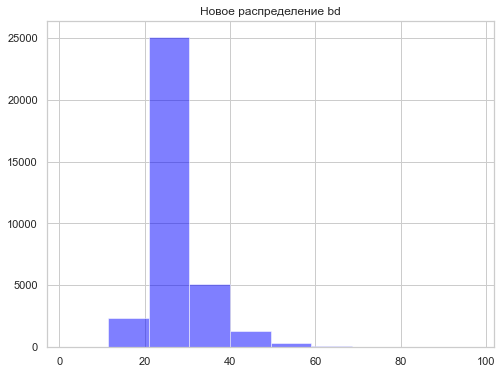

In [60]:
plt.figure(figsize=(8, 6))

members_df['bd'].hist(bins=10, color='blue', alpha=0.5)

plt.title('Новое распределение bd')

plt.show()

То же самое делаем для гендера

In [61]:
train_gender =  members_df[members_df['gender'] != 0].copy() 
y_train_gender  = train_gender['gender']
train_gender.drop(['msno','gender'],axis = 1 , inplace = True)

test_gender =  members_df[members_df['gender'] == 0].copy() 
y_test_gender  = test_gender['gender']
test_gender.drop(['msno' ,'gender'],axis = 1 , inplace = True)

In [62]:
model = CatBoostClassifier(task_type='GPU', verbose=0)
model.fit(train_gender.values, y_train_gender.values)
cv_score = cross_val_score(model, train_gender.values,y_train_gender.values.ravel(), cv=3, scoring='accuracy').mean()
cv_score

0.5220332345406212

In [63]:
pred_gender = model.predict(test_gender.values)

In [64]:
members_df['gender'].value_counts()

gender
0    19902
2     7405
1     7096
Name: count, dtype: int64

In [65]:
gender_nulls_indexes = members_df[members_df['gender'] == 0].index
j = 0
for i in gender_nulls_indexes : 
    members_df.loc[i , 'gender'] = pred_gender[j]
    j += 1

In [66]:
members_df['gender'].value_counts()

gender
2    22241
1    12162
Name: count, dtype: int64

In [67]:
members_df.head()

,msno,city,bd,gender,registered_via,reg_year,reg_month,reg_day,exp_year,exp_month,exp_day
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,35,1,7,2011,8,20,2017,9,20
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,26,1,7,2015,6,28,2017,6,22
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,25,2,4,2016,4,11,2017,7,12
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,29,1,9,2015,9,6,2015,9,7
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,26,1,4,2017,1,26,2017,6,13


Формируем общий датасет для обучения

In [68]:
y = train_df['target'].values

all_data = train_df.drop('target', axis =1)
all_data.shape

(7377418, 5)

In [70]:
all_data = all_data.merge(members_df, on='msno', how='left')

In [71]:
all_data = all_data.merge(songs_df, on = 'song_id', how = 'left')

Удаляем неиспользующиеся данные

In [72]:
del [[members_df,songs_df]]
import gc
gc.collect()

201902

In [73]:
for i in range(0,8):
    all_data[i] = all_data[i].fillna(0)

In [74]:
all_data[0].value_counts()

0
465     3814444
458     1266910
921      400596
1609     329134
444      280278
         ...   
1187          1
1579          1
2015          1
779           1
87            1
Name: count, Length: 160, dtype: int64

In [75]:
for i in range(0,8):
    all_data[i] = all_data[i].astype('category').cat.codes

In [76]:
all_data[0].value_counts()

0
114    3814444
113    1266910
149     400596
45      329134
111     280278
        ...   
28           1
42           1
62           1
134          1
143          1
Name: count, Length: 160, dtype: int64

In [77]:
nulls_cols = all_data.isnull().sum()
nulls_cols = nulls_cols[nulls_cols != 0]
list(nulls_cols.keys())

['song_length', 'artist_name', 'composer', 'lyricist', 'language']

In [78]:
for col in list(nulls_cols.keys()): 
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [79]:
all_data.isnull().sum()

msno                  0
song_id               0
source_system_tab     0
source_screen_name    0
source_type           0
city                  0
bd                    0
gender                0
registered_via        0
reg_year              0
reg_month             0
reg_day               0
exp_year              0
exp_month             0
exp_day               0
song_length           0
artist_name           0
composer              0
lyricist              0
language              0
0                     0
1                     0
2                     0
3                     0
4                     0
5                     0
6                     0
7                     0
dtype: int64

In [80]:
all_data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,reg_year,...,lyricist,language,0,1,2,3,4,5,6,7
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,30,2,7,2012,...,,52.0,101,0,0,0,0,0,0,0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,13,24,1,9,2011,...,,52.0,33,0,0,0,0,0,0,0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,13,24,1,9,2011,...,,52.0,33,0,0,0,0,0,0,0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,13,24,1,9,2011,...,,-1.0,5,0,0,0,0,0,0,0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,30,2,7,2012,...,,52.0,4,0,0,0,0,0,0,0


In [81]:
all_data[['composer']].nunique()

composer    75859
dtype: int64

In [82]:
categorical_col = ['city','gender','registered_via','language','artist_name','composer','lyricist']
for col in all_data.columns:
    if all_data[col].dtype in [bool ,object, 'category'] and len(all_data[col].unique()) <= 50:
        categorical_col.append(col)

In [83]:
categorical_col

['city',
 'gender',
 'registered_via',
 'language',
 'artist_name',
 'composer',
 'lyricist',
 'source_system_tab',
 'source_screen_name',
 'source_type']

In [84]:
for col in categorical_col:
    if all_data[col].dtype == 'float16':
        all_data[col] = all_data[col].astype('float32')

    all_data[col] = all_data[col].astype('category').cat.codes

In [85]:
all_data.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,city,bd,gender,registered_via,reg_year,...,lyricist,language,0,1,2,3,4,5,6,7
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,2,8,7,0,30,1,2,2012,...,0,8,101,0,0,0,0,0,0,0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,4,9,5,11,24,0,3,2011,...,0,8,33,0,0,0,0,0,0,0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,4,9,5,11,24,0,3,2011,...,0,8,33,0,0,0,0,0,0,0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,4,9,5,11,24,0,3,2011,...,0,0,5,0,0,0,0,0,0,0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,2,8,7,0,30,1,2,2012,...,0,8,4,0,0,0,0,0,0,0


In [86]:
all_data['msno'].value_counts()

msno
MXIMDXO0j3UpaT7FvOSGW6Y5zfhlh+xYjTqGoUdMzEE=    5819
o+5RNlSWrzvrphgBNGIo1FLkGxBgyICns6qXj3nS7Pk=    5537
FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=    5511
KGXNZ/H3VxvET/+rGxlrAe7Gpz2eKMXyuSg3xh8Ij1M=    4217
cqjRBV/jWN2ujhc+z/4tz+Mj6xEfflAAt6qBXCqxKvw=    4008
                                                ... 
dFn+y4sy0eSX+AO8XyYDtJD6lXnCK5NrJ5CVdHhDWSc=       1
OFkQCandGEPRN4iPq48jSjCJerSplGddZ7s8iphDnRI=       1
xLvdozJTsNThedqu4yX9+nPDw2xi9SfiDd5AjNk2EHM=       1
PXf4wzIDMBFS/TYu0WcjSwp6li+8kuVOK3o7UkpjqDE=       1
oHMpaCQRI6fzq/jamfTvv5tFfukkE9/VERi7/CfQ9M0=       1
Name: count, Length: 30755, dtype: int64

In [88]:
all_data.columns = all_data.columns.astype(str)

Разделяем датасет на тестовую и обучающую выборку

In [90]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_data, y, test_size=0.1, random_state=2)

X_train.shape, X_test.shape

((6639676, 28), (737742, 28))

In [92]:
y_train

array([False, False, False, ...,  True,  True,  True])

In [95]:
y_train = y_train.astype(int)

In [97]:
X_train = X_train.drop(['msno','song_id'], axis = 1)
X_test = X_test.drop(['msno','song_id'],axis = 1)

X_train.shape , X_test.shape

((6639676, 26), (737742, 26))

Стандартизируем значения

In [103]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, PowerTransformer

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [104]:
X_train = X_train_scaled
test_data = X_test_scaled

Обучаем модель

In [105]:
import lightgbm as lgb

train_set = lgb.Dataset(X_train , y_train)
params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'learning_rate': 0.3 ,
        'verbose': 0,
        'num_leaves': 200,
        'max_bin': 510,
        'max_depth': 20,
        'metric' : 'auc'
    }

%time model_f1 = lgb.train(params, train_set=train_set,  valid_sets=train_set)

CPU times: total: 5min 24s
Wall time: 1min 57s


In [107]:
predictions = model_f1.predict(pd.DataFrame(test_data).values)
predictions

array([0.5947688 , 0.30704654, 0.60349893, ..., 0.70966674, 0.56318943,
       0.74780345])

Оцениваем

In [112]:
def dcg_at_k(r, k):
    """Вычисление DCG@k"""
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0

def ndcg_at_k(r, k):
    """Вычисление NDCG@k"""
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0
    return dcg_at_k(r, k) / dcg_max

ndcg_score = ndcg_at_k(predictions, 20)
print("NDCG@6:", ndcg_score)

NDCG@6: 0.4668587789021514
